<center><a href="https://colab.research.google.com/github/AlisonJD/RTACourse/blob/main/04_Source_Data_and_Ingestion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a></center>

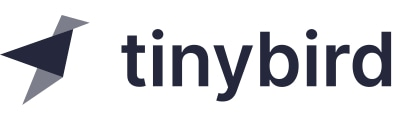
#Principles of Real-Time Analytics Course

#Source Data and Ingestion
The first step towards analyzing data is to load the data. Although this sounds like a trivial thing (doing some inserts is easy), it is actually a critical part of working with data at scale. The focus of this section is to understand the different data formats and how to ingest data properly to an analytics database.

You will see how even the source of your data impacts on how you send it to your data systems: a bank might send information once a day, embedded software tracking a bus in NYC sends it every few seconds.


##Important Metrics
Key metrics for ingesting data are:
 - the speed of ingestion (**rate**)
 - how much data is being ingested (**size**).

That’s it, how often the source pushes data and how large is the data it pushes. For example, a bus fleet management software could be sending 100-200 rows per second, 100 bytes each, another system could be sending 1 GB per hour; those cases need to be treated in different ways.

The key as always is to try to process data in larger batches. It is usually faster to process 1M rows all at once than 10 rows in 100 000 different batches. The reason is clear, devices work much faster when working on large portions of data for reading and that’s also true for writing.

That’s not the only reason, real-time analytics databases generally use algorithms to deal with data in the background. We will see that later.

So, for example, a high-rate low-size use case, such as fleet management, usually needs to buffer data for a while and then insert the data. If you want a really low-latency value you may want to use any streaming solution for analytics. A system that sends 1 GB each hour is fine, there’s no need for buffering.  


##Types of Data Sources
People usually have a series of data sources and the problem is how to organize them in order to work with them. When you are dealing with large volumes of data the probability that you get data that is not as you expected is really high.

Fundamentally there are three types of data source:
 - Streams or logs - event-driven data generated by an application, usually you use Kafka or similar when the data rate and volume is really high, for example, events coming from tracking user activity
 - Transactional data where you take a snapshot at a moment in time - web applications, for example banks, e-commerce and most web applications. You can add, change, delete and update data.
 - Raw data stored in files (for example, CSV or JSON). This can be considered to be a persistent log.


##Data Formats
It’s not only the data format, it’s also the way the data is stored. For example, you can have a single CSV file, the same data but in multiple CSV files, a large compressed zip file, the same but gzipped, multiple gzip files…

There are many different types of data files: 
- format: CSV, JSON, Parquet, SQLite, Avro, Arrow…
- storage: XML, JSON, JSONL, CSV, TSV, CSV.zip, CSV.gz. 

In general, the important thing to remember is that working with large files, especially if they are compressed in zip is a huge pain. It is always preferable to divide your huge 5 GB CSV into 5 files of 1 GB, or even into 20 files and to compress with something streamable like gz. Then you can process them in batches; each file can be a partition, for example, data for January. Storing them compressed means saving money on storage and sending them through the network is faster (you should always compress data that goes through the network). That’s the way Parquet and other similar systems do this. 

Good practice here is:
- work with medium sized files, not a single large file nor many small files
- use compression that allows parallelization
- use open and standard formats
- use binary files when you can
partition data in a way that fits the business.

Note that although CSV and JSON are the most popular data formats to move data between data systems they have the problem of non-deterministic data types. If the data is stored in a database the format will obviously be the internal one but the most common way to move that data out is usually to transform to CSV or JSON.


##Structured vs. Unstructured Data
When running real-time analytics, unstructured data generally means slow. Structured and homogeneous data is nearly always much, much faster than unstructured data. Therefore, we will focus here on structured data.  If we have unstructured data, such as events in JSON, what we generally do is load the unstructured data, keep it in a table and then create views where we extract the columns from the JSON that we need to work with. Thereby converting unstructured data into structured data.

If you are looking for something that is very general for unstructured data then you need a technology like MongoDB or Elastic; this is not the right place for that. 


##Events Tables and Dimension Tables
When dealing with large datasets there is a typical pattern that emerges every time with two main groups in the data: events tables and dimension tables. This is not something new, it’s usually called the [star schema](https://en.wikipedia.org/wiki/Star_schema). We don’t actually care about the names, we really do care about things working well no matter what the name is.

Events tables (such as transactions in bank accounts) grow very fast while dimension tables (such as clients) grow much more slowly and are generally way smaller than events tables. In the bus fleet example, the bus positions will be events, while the route and driver properties will be dimensions.

It is important to keep in mind what sort of table we are dealing with because this will condition decisions about storing data and preparing queries. From now on we will talk about
 - dimension tables: small (less than a few million items) which often change.
 - event tables: large and usually append only.


##Ingestion Patterns
When you have historic data stored somewhere then the ingestion pattern is clear. Push the CSV, JSON or whatever to the database and that’s it. The only thing that you need to take into account is ensuring that while the database is ingesting data it’s not using those resources to run queries. We will see how to try to fix this issue when we talk about cluster sizing.

If you are loading data from some event stream (it doesn’t matter if it is Kafka or your own application) it’s easy: just capture the events you want to use, buffer them and dump them into a table using an insert or a copy in the same way you’d do in your transactional database. The main difference to a transactional database is that you should try to insert the data in batches rather than one by one.

The problem comes when you have a more transactional database and the amount of data becomes unmanageable so you want to move it to an analytics database. This is a problem because you need to sync data between two systems that usually work in a different way.

There are different patterns to load data from PostgreSQL, MySQL, Db2 tables or MongoDB, Elastic collections:

- Incremental: send new data every X minutes/seconds to the analytics database. This is the easiest way but sometimes schemas on original databases save a snapshot, not the history (i.e, updates and deletes are executed not only appends). 

- Upsert: you send all the data for the last X hours every Y minutes/seconds. So new data will be inserted and old data will be updated. This case is useful when you have a table and you update data, that is what most of the regular web applications do. The problem with this approach is that analytics databases don’t usually support upserts or, at least, not in real-time.

- Full replace: this is the brute force approach, dump all the data and load it on the analytics database. It’s usually a non-viable option for reasons related to data size. However, this works pretty well for dimension tables which are usually small (less than a couple of hundred MB most of the time).

The reality is that most of the sync use cases are easily solved with a cron job, Airflow task or, if you are unlucky, a control-m job.

## [Course Outline](https://colab.research.google.com/github/AlisonJD/RTACourse/blob/main/01_Getting_Started.ipynb)


|Previous Notebook       |Next Notebook|
| :----------------- |:-------------|
|3. [Use the Right Database](https://colab.research.google.com/github/AlisonJD/RTACourse/blob/main/03_Use_the_Right_Database.ipynb)|5. [Data Storage Inside the Analytics Database](https://colab.research.google.com/github/AlisonJD/RTACourse/blob/main/05_Data_Storage_Inside_the_Analytics_Database.ipynb)|